In [4]:
!pip install gym torch torchvision

In [ ]:
!sudo apt-get update
!sudo apt-get install -y build-essential swig

In [ ]:
!pip install gym[box2d]

In [31]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque

In [32]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [33]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

In [34]:
class Expert:
    def __init__(self, env):
        self.env = env
        self.expert_policy = self.load_expert_policy()

    def load_expert_policy(self):
        # Здесь должен быть код для загрузки политики эксперта
        return np.random.rand(1000, self.env.action_space.shape[0])

    def get_expert_action(self, state):
        index = np.random.randint(len(self.expert_policy))
        return self.expert_policy[index]

In [60]:
class SQILAgent:
    def __init__(self, state_dim, action_dim):
        self.q_network = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.replay_buffer = deque(maxlen=10000)
        self.expert_data = []

    def add_expert_data(self, state, action):
        self.expert_data.append((state, action))

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = self.q_network(state_tensor).detach().numpy()[0]
        return action

    def train(self, batch_size):
      if len(self.replay_buffer) < batch_size:
          return

      batch = np.random.choice(len(self.replay_buffer), batch_size)
      states, actions = zip(*[self.replay_buffer[i] for i in batch])

      states = torch.FloatTensor(states)
      actions = torch.FloatTensor(actions)

      q_values = self.q_network(states)

      rewards = torch.zeros(batch_size)
      for i, (state, action) in enumerate(zip(states, actions)):
          if any(np.array_equal(state.numpy(), ex_state) and np.array_equal(action.numpy(), ex_action)
                for ex_state, ex_action in self.expert_data):
              rewards[i] = 1


      action_indices = actions.argmax(dim=1)
      q_values_for_actions = q_values.gather(1, action_indices.unsqueeze(1))

      rewards = rewards.unsqueeze(1)

      loss = nn.MSELoss()(q_values_for_actions, rewards)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

In [36]:
class SACAgent:
    def __init__(self, state_dim, action_dim):
        self.q1_network = QNetwork(state_dim, action_dim)
        self.q2_network = QNetwork(state_dim, action_dim)
        self.policy_network = PolicyNetwork(state_dim, action_dim)

        self.q1_optimizer = optim.Adam(self.q1_network.parameters(), lr=0.001)
        self.q2_optimizer = optim.Adam(self.q2_network.parameters(), lr=0.001)
        self.policy_optimizer = optim.Adam(self.policy_network.parameters(), lr=0.001)

        self.replay_buffer = deque(maxlen=10000)
        self.gamma = 0.99

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = self.policy_network(state_tensor).detach().numpy()[0]
        return action

    def add_to_replay_buffer(self, transition):
        self.replay_buffer.append(transition)

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return

        batch = np.random.choice(len(self.replay_buffer), batch_size)
        states, actions, rewards, next_states, dones = zip(*[self.replay_buffer[i] for i in batch])

        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        with torch.no_grad():
            next_actions = self.policy_network(next_states)
            q1_next = self.q1_network(next_states)
            q2_next = self.q2_network(next_states)
            target_q = rewards + (1 - dones) * self.gamma * torch.min(q1_next, q2_next)

        q1_values = self.q1_network(states)
        q2_values = self.q2_network(states)

        q1_loss = nn.MSELoss()(q1_values, target_q)
        q2_loss = nn.MSELoss()(q2_values, target_q)

        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        policy_loss = -self.q1_network(states).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

In [37]:
def train_sqil_agent(env, agent, expert, episodes):
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = expert.get_expert_action(state)
            agent.add_expert_data(state, action)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.append((state, action))
            state = next_state
            agent.train(64)

In [38]:
def train_sac_agent(env, agent, episodes):
    rewards_list = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.add_to_replay_buffer((state, action, reward, next_state, done))
            agent.train(64)
            state = next_state
            total_reward += reward
        rewards_list.append(total_reward)
    return rewards_list

In [39]:
def plot_results(sqil_rewards, sac_rewards):
    plt.plot(sqil_rewards, label='SQIL')
    plt.plot(sac_rewards, label='SAC')
    plt.xlabel('Эпизоды')
    plt.ylabel('Награда')
    plt.legend()
    plt.title('Сравнение SQIL и SAC')
    plt.show()

In [40]:
env = gym.make('LunarLanderContinuous-v2')

In [41]:
expert = Expert(env)

In [61]:
sqil_agent = SQILAgent(state_dim=8, action_dim=2)
train_sqil_agent(env, sqil_agent, expert, 100)

KeyboardInterrupt: 

In [58]:
sac_agent = SACAgent(state_dim=8, action_dim=2)
sac_rewards = train_sac_agent(env, sac_agent, 100)

In [ ]:
plot_results(sqil_agent.replay_buffer, sac_rewards)

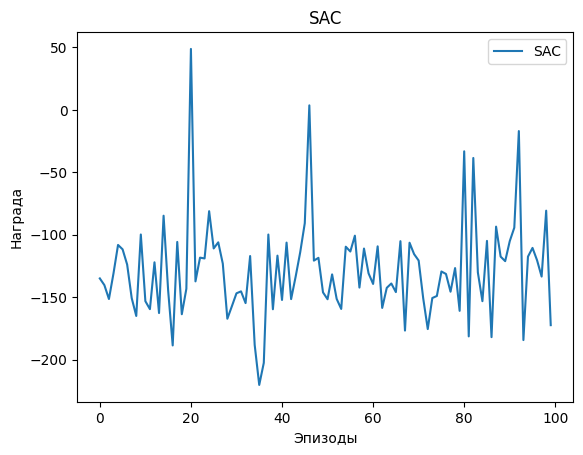

In [63]:
plt.plot(sac_rewards, label='SAC')
plt.xlabel('Эпизоды')
plt.ylabel('Награда')
plt.legend()
plt.title('SAC')
plt.show()